In [1]:
import pandas as pd
from sklearn.datasets import load_linnerud
from tsai.all import *

epochs = 300

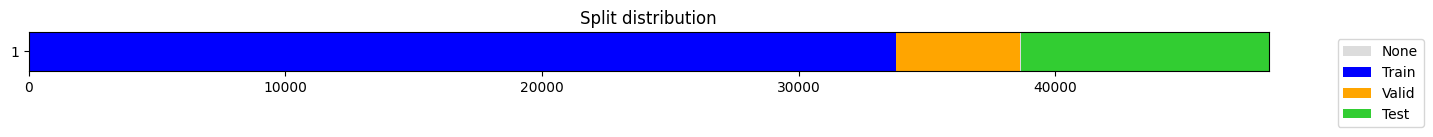

((48384, 48),
 (48384, 1),
 ((#33804) [0,1,2,3,4,5,6,7,8,9...],
  (#4829) [33815,33816,33817,33818,33819,33820,33821,33822,33823,33824...],
  (#9658) [38655,38656,38657,38658,38659,38660,38661,38662,38663,38664...]))

In [2]:
df = pd.read_csv("merged.csv")
# df.describe().T.to_csv("describe_merged.csv")
X_cols = list(pd.read_csv("control.csv").columns)

y_cols = ["INNER_TPRT_1"] 
X_cols.remove(y_cols[0])
X_raw = df[X_cols]
X, y = df[X_cols].to_numpy(), df[y_cols].to_numpy()

datetime_col = "MSRM_DT"
fcst_history = 60 # # steps in the past
fcst_horizon = 12  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_forecasting_splits(
    df, fcst_history=fcst_history, 
    fcst_horizon=fcst_horizon, datetime_col=datetime_col,
    valid_size=valid_size, test_size=test_size
)

X.shape, y.shape, splits

TSTensor(samples:64, vars:1, len:48, device=cuda:0, dtype=torch.float32)


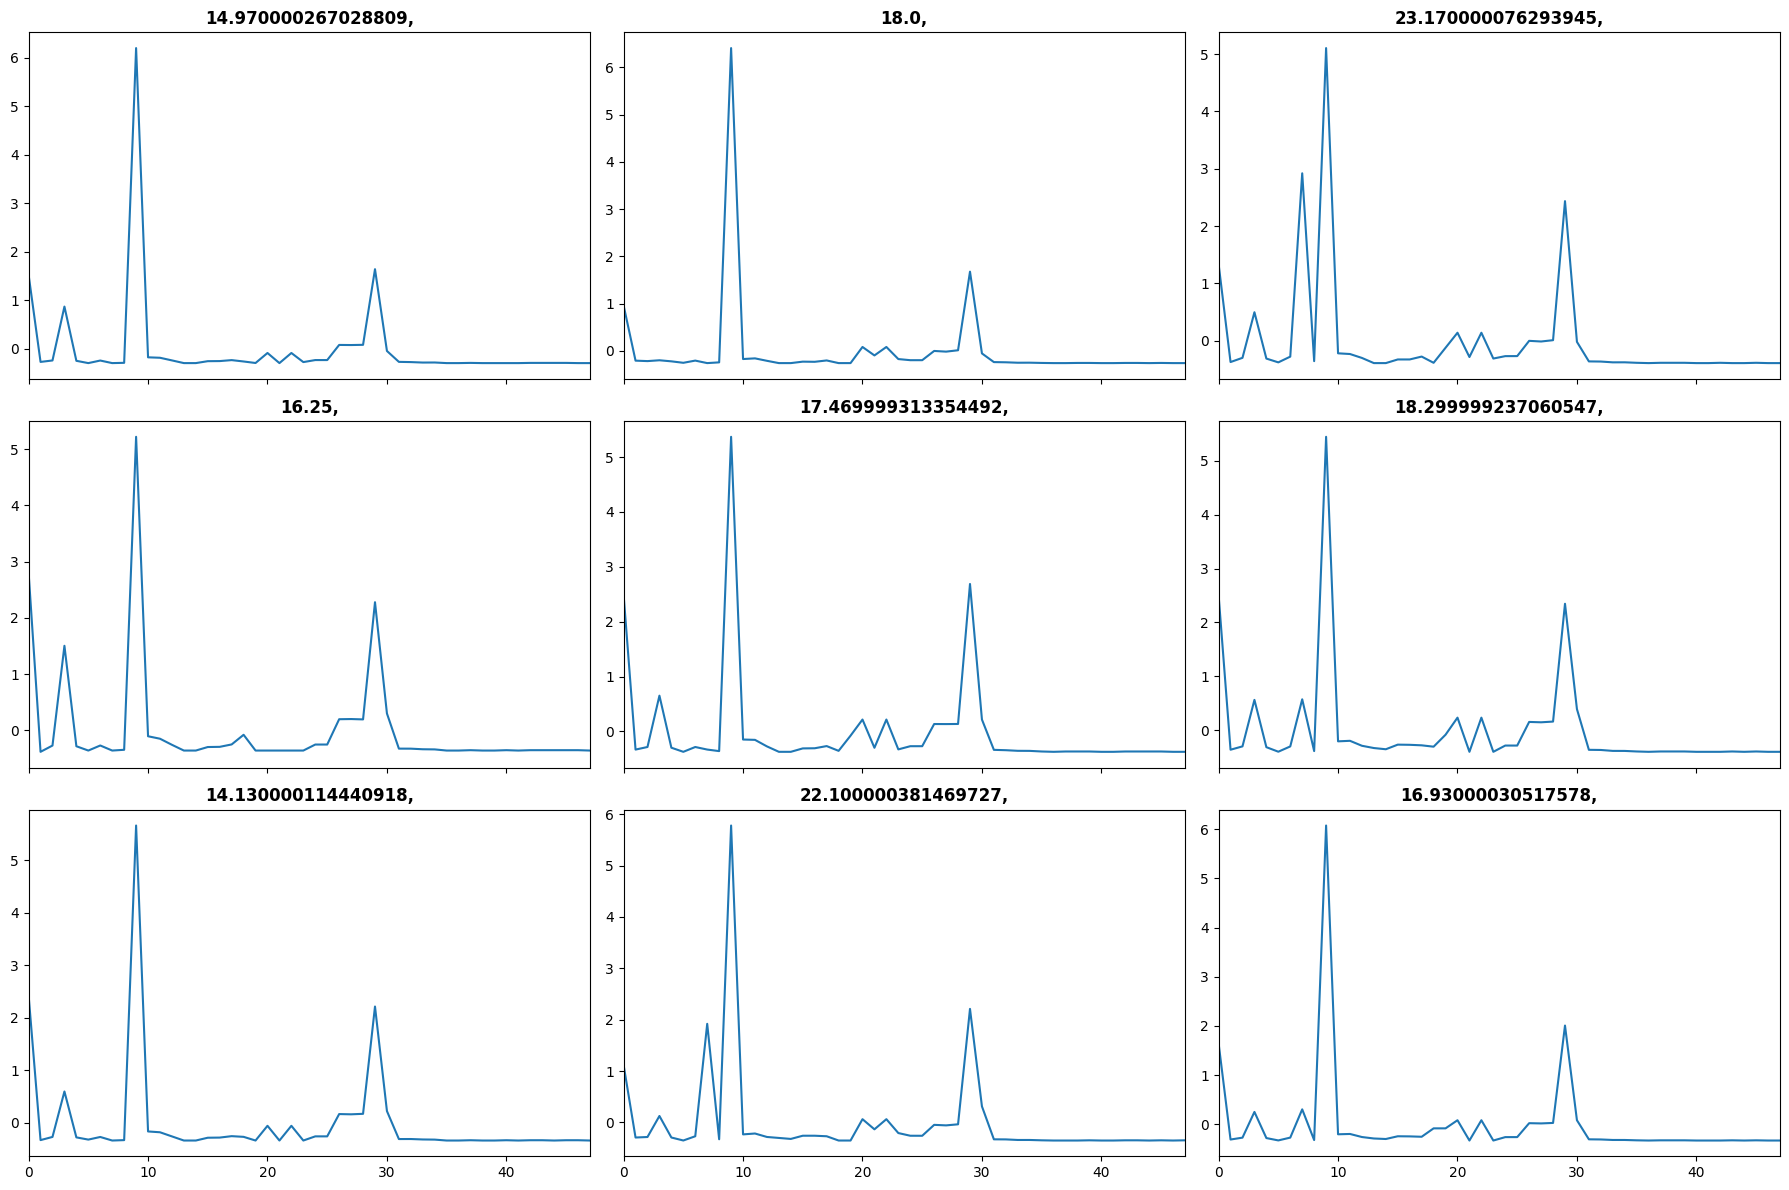

In [3]:
tfms = [None, TSRegression()]
batch_tfms = [
    TSStandardize(by_sample=True),
    # TSNormalize(), TSToPlot(),
    # TSNormalize(), TSToMat(),
    # TSNormalize(), TSToGADF()
]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, 
    batch_tfms=batch_tfms)
    
print(dls.one_batch()[0])
dls.show_batch()


arch: PatchTST(c_in=1 c_out=1 seq_len=48 pred_dim=1 arch_config={}, kwargs={})


epoch,train_loss,valid_loss,mse,time
0,3.130639,5.065761,5.065761,00:05
1,2.493838,4.216451,4.216451,00:05
2,2.042870,3.325829,3.325829,00:05
3,1.919520,2.988161,2.988161,00:05
4,1.673668,2.920593,2.920593,00:05
5,1.586028,2.317976,2.317976,00:05
6,1.430616,2.374826,2.374826,00:05
7,1.357815,2.075402,2.075402,00:06
8,1.284206,2.399032,2.399032,00:05
9,1.170812,1.773288,1.773288,00:05


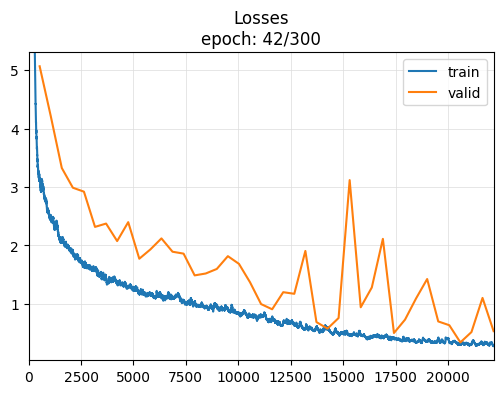

In [4]:
# 35min

reg = TSRegressor(
    X, y, splits=splits, 
    path='models', arch="PatchTST", 
    tfms=tfms, batch_tfms=batch_tfms, 
    metrics=[mse], cbs=ShowGraph(), verbose=True
)
lr = reg.lr_find()
reg.fit_one_cycle(epochs, lr)
reg.export("reg.pkl")


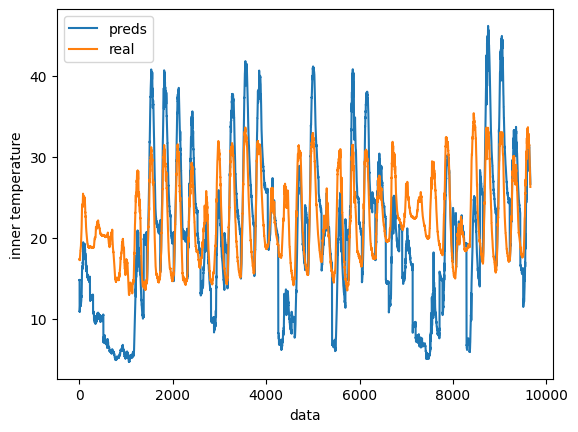

In [ ]:
from tsai.inference import load_learner

learn = load_learner("models/reg.pkl", cpu=False)

raw_preds, _, preds = learn.get_X_preds(
    X[splits[2]].reshape(1, -1, len(X_cols))
)

# Test data
plt.plot(preds[0], label="preds")
plt.plot(y[splits[2]], label="real")
plt.xlabel("data")
plt.ylabel("inner temperature")
plt.legend()


In [ ]:
X[0]

array([521.  ,  -1.35,  13.35, 276.  ,  11.45,   0.  ,  13.4 ,   0.  ,
         1.95, 952.  ,  39.  ,  28.8 ,  16.  ,   0.  ,   0.  ,   9.5 ,
        10.  ,  16.5 , 100.  ,  25.  ,   0.  ,   0.  ,   0.  ,   0.  ,
        15.85,  15.65,  86.15,  87.05,  85.25, 537.  , 100.  ,   5.4 ,
         5.2 ,   3.5 ,   3.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   1.  ,   1.  ,   0.  ,   1.  ,   1.  ,   0.  ])

In [ ]:
X[splits[1]].reshape(1, -1, len(X_cols)).shape, len(preds[0]), len(raw_preds[0])

((1, 4829, 48), 4829, 4829)

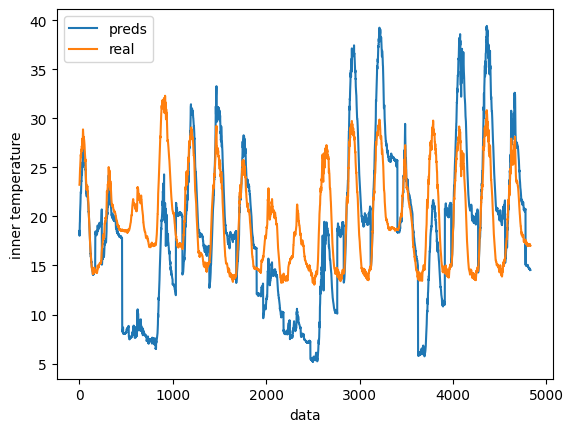

In [ ]:
# validation data
raw_preds, _, preds = learn.get_X_preds(
    X[splits[1]].reshape(1, -1, len(X_cols))
)

plt.plot(preds[0], label="preds")
plt.plot(y[splits[1]], label="real")
plt.xlabel("data")
plt.ylabel("inner temperature")
plt.legend()

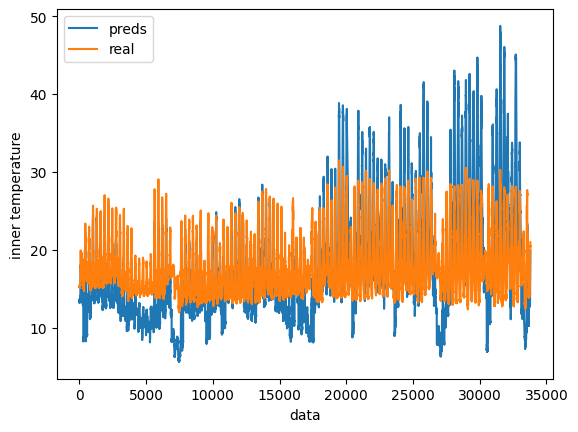

In [ ]:
# train data
raw_preds, _, preds = learn.get_X_preds(
    X[splits[0]].reshape(1, -1, len(X_cols))
)
plt.plot(preds[0], label="preds")
plt.plot(y[splits[0]], label="real")
plt.xlabel("data")
plt.ylabel("inner temperature")
plt.legend()